<a href="https://colab.research.google.com/github/pravallika322/sentimental-analysis-based-on-twitter-data/blob/main/Ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Transformers imports
from transformers import BertTokenizer, RobertaTokenizer, TFBertModel, TFRobertaModel

# Random seed fix for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
# Load your depressed / non-depressed tweets CSV files
d_path = '/content/d_tweets.csv'
non_d_path = '/content/non_d_tweets.csv'

d_tweet_df = pd.read_csv(d_path).dropna(subset=['tweet'])
non_d_tweet_df = pd.read_csv(non_d_path).dropna(subset=['tweet'])

d_tweet_df['label'] = 1
non_d_tweet_df['label'] = 0

all_data = pd.concat([d_tweet_df, non_d_tweet_df], ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)

# Check class distribution
print(all_data['label'].value_counts())


label
0    4809
1    3496
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    all_data['tweet'], all_data['label'],
    test_size=0.2,
    stratify=all_data['label'],
    random_state=seed
)


In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def encode_text(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_attention_mask=True,
        return_tensors='tf'
    )

# Encode for BERT
X_train_enc_bert = encode_text(X_train, bert_tokenizer)
X_test_enc_bert = encode_text(X_test, bert_tokenizer)

# Encode for RoBERTa
X_train_enc_roberta = encode_text(X_train, roberta_tokenizer)
X_test_enc_roberta = encode_text(X_test, roberta_tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [ ]:
# BERT Model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids_bert = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids_bert')
attention_mask_bert = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask_bert')

bert_output = bert_model(input_ids_bert, attention_mask=attention_mask_bert)[1]  # pooled_output
bert_dense = tf.keras.layers.Dense(1, activation='sigmoid')(bert_output)

bert_classifier = tf.keras.Model(inputs=[input_ids_bert, attention_mask_bert], outputs=bert_dense)
bert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                        loss='binary_crossentropy', metrics=['accuracy'])


# RoBERTa Model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
input_ids_roberta = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids_roberta')
attention_mask_roberta = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask_roberta')

roberta_output = roberta_model(input_ids_roberta, attention_mask=attention_mask_roberta)[1]  # pooled_output
roberta_dense = tf.keras.layers.Dense(1, activation='sigmoid')(roberta_output)

roberta_classifier = tf.keras.Model(inputs=[input_ids_roberta, attention_mask_roberta], outputs=roberta_dense)
roberta_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                          loss='binary_crossentropy', metrics=['accuracy'])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were 

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
history_bert = bert_classifier.fit(
    [X_train_enc_bert['input_ids'], X_train_enc_bert['attention_mask']],
    y_train,
    validation_data=([X_test_enc_bert['input_ids'], X_test_enc_bert['attention_mask']], y_test),
    epochs=3,
    batch_size=16,
    shuffle=True
)

history_roberta = roberta_classifier.fit(
    [X_train_enc_roberta['input_ids'], X_train_enc_roberta['attention_mask']],
    y_train,
    validation_data=([X_test_enc_roberta['input_ids'], X_test_enc_roberta['attention_mask']], y_test),
    epochs=3,
    batch_size=16,
    shuffle=True
)


Epoch 1/3
416/416 [==============================] - 233s 439ms/step - loss: 0.2280 - accuracy: 0.9076 - val_loss: 0.1773 - val_accuracy: 0.9296
Epoch 2/3
416/416 [==============================] - 185s 445ms/step - loss: 0.0897 - accuracy: 0.9690 - val_loss: 0.2377 - val_accuracy: 0.9259
Epoch 3/3
416/416 [==============================] - 179s 431ms/step - loss: 0.0367 - accuracy: 0.9880 - val_loss: 0.2587 - val_accuracy: 0.9344
Epoch 1/3
416/416 [==============================] - 232s 464ms/step - loss: 0.2329 - accuracy: 0.9028 - val_loss: 0.1370 - val_accuracy: 0.9518
Epoch 2/3
416/416 [==============================] - 186s 447ms/step - loss: 0.1022 - accuracy: 0.9612 - val_loss: 0.1837 - val_accuracy: 0.9416
Epoch 3/3
416/416 [==============================] - 186s 447ms/step - loss: 0.0597 - accuracy: 0.9774 - val_loss: 0.1474 - val_accuracy: 0.9488


In [ ]:
# Get prediction probabilities (between 0-1)
bert_probs = bert_classifier.predict([X_test_enc_bert['input_ids'], X_test_enc_bert['attention_mask']]).flatten()
roberta_probs = roberta_classifier.predict([X_test_enc_roberta['input_ids'], X_test_enc_roberta['attention_mask']]).flatten()

# Average the probabilities - soft voting/fuzzy ensemble
ensemble_probs = (bert_probs + roberta_probs) / 2.0

# Convert to binary predictions with threshold 0.5
ensemble_preds = (ensemble_probs > 0.5).astype(int)


52/52 [==============================] - 16s 257ms/step


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       962
           1       0.94      0.93      0.94       699

    accuracy                           0.95      1661
   macro avg       0.95      0.94      0.94      1661
weighted avg       0.95      0.95      0.95      1661



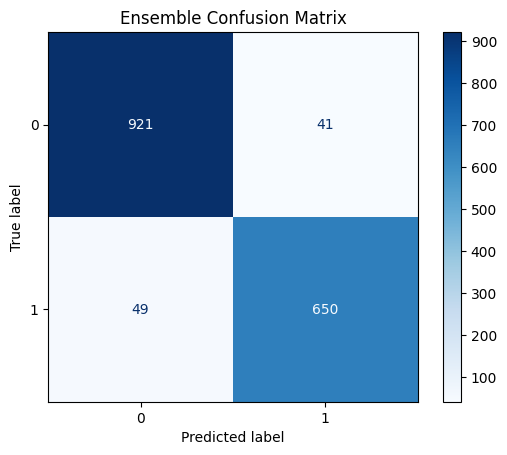

In [ ]:
print(classification_report(y_test, ensemble_preds))

cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Ensemble Confusion Matrix')
plt.show()


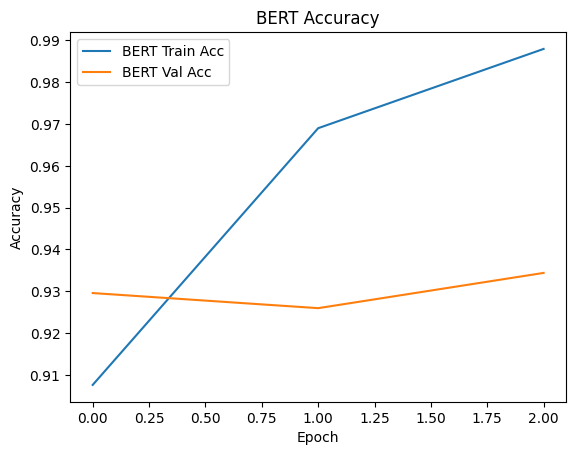

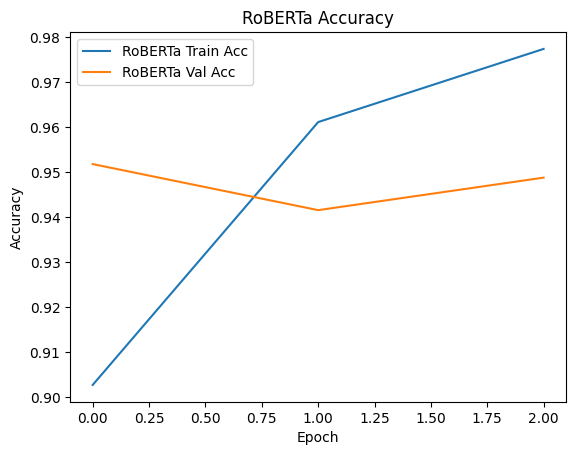

In [ ]:
plt.plot(history_bert.history['accuracy'], label='BERT Train Acc')
plt.plot(history_bert.history['val_accuracy'], label='BERT Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('BERT Accuracy')
plt.legend()
plt.show()

plt.plot(history_roberta.history['accuracy'], label='RoBERTa Train Acc')
plt.plot(history_roberta.history['val_accuracy'], label='RoBERTa Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RoBERTa Accuracy')
plt.legend()
plt.show()
